In [2]:
!pip install Augmentor

In [3]:
!pip install split-folders

In [4]:
import numpy as np
import cv2
import Augmentor
import matplotlib.pyplot as plt
import os
import splitfolders
from PIL import Image
from os import listdir
from os.path import splitext
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
scr_dir = "/content/drive/MyDrive/brain_tumor_dataset"

In [6]:
columns = 2
rows = 2

In [7]:
def get_path_subdir(root_folder):
    paths = []
    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)
        if os.path.isdir(folder_path):
            paths.append(folder_path)
    return paths

In [8]:
def pick_image(dir_path):
    file_paths = []
    for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        if not os.path.isdir(file_path):
            file_paths.append(file_path)
    image_paths = set()
    while len(image_paths) < 4:
        image_paths.add(np.random.randint(0,len(file_paths)-1))
    image_paths = [file_paths[i] for i in list(image_paths)]
    return image_paths

In [9]:
def plot_images(image_paths):
    fig = plt.figure(figsize=(15, 10))
    for idx in range(len(image_paths)):
        path = image_paths[idx]
        fig.add_subplot(rows, columns, idx+1)
        image = cv2.imread(path)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

In [10]:
dir_paths = get_path_subdir(scr_dir)

In [11]:
image_paths = pick_image(dir_paths[0])

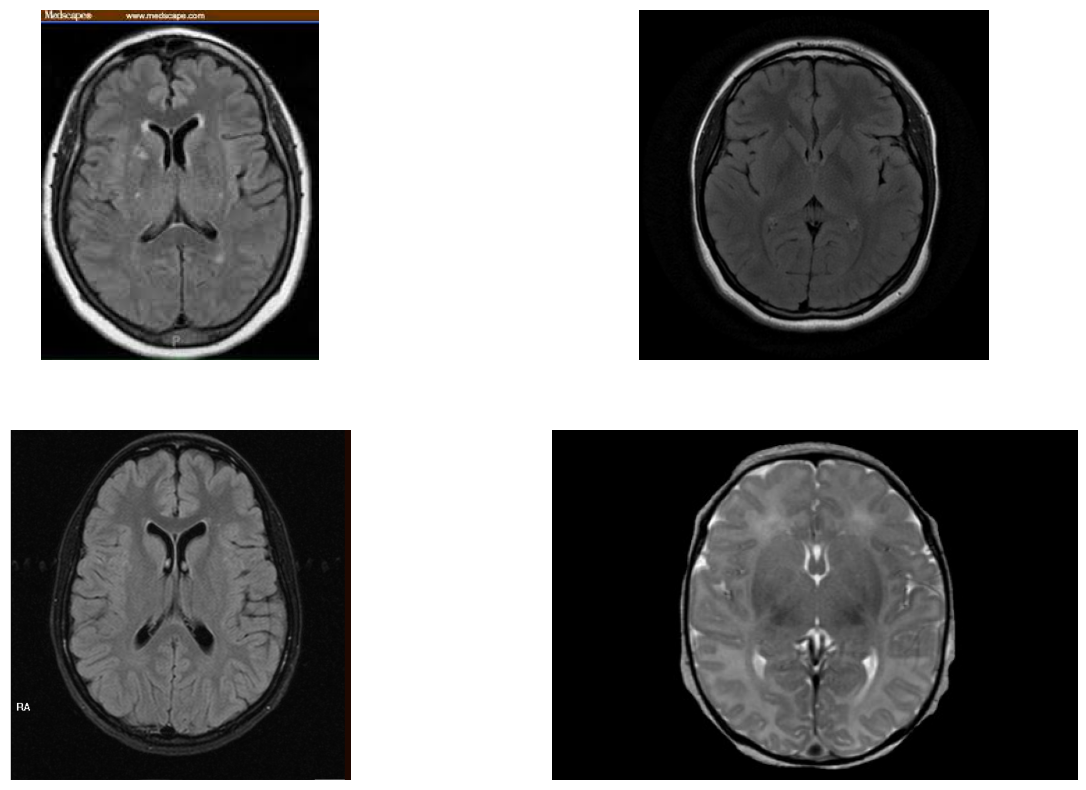

In [12]:
plot_images(image_paths)

In [13]:
splitfolders.ratio(scr_dir, output="data", seed=10, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 253 files [00:17, 14.07 files/s] 


In [14]:
def get_augmentor(source_folder, dest_folder):
    # Create a pipeline
    augmentor = Augmentor.Pipeline(source_folder, dest_folder, save_format='jpg')
    # Rotation
    augmentor.rotate(probability=0.5, max_left_rotation=3, max_right_rotation=3)
    # Flip
    augmentor.flip_left_right(probability=0.3)
    augmentor.flip_top_bottom(probability=0.3)
    augmentor.rotate90(probability=0.3)
    augmentor.rotate180(probability=0.3)
    augmentor.rotate270(probability=0.3)
    # Skew
    augmentor.skew_tilt(probability=0.3)
    augmentor.skew_left_right(probability=0.3)
    augmentor.skew_top_bottom(probability=0.3)
    augmentor.skew_corner(probability=0.3)
    augmentor.skew(probability=0.5)
    # Mirror
    augmentor.flip_left_right(probability=0.5)
    augmentor.flip_top_bottom(probability=0.3)
    augmentor.flip_random(probability=0.3)
    # Random Brightness
    augmentor.random_brightness(probability = 0.5, min_factor=0.4, max_factor=0.9)
    # Random Contrast
    augmentor.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)
    # Random Distortion
    augmentor.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
    # Random Erasing
    augmentor.random_erasing(probability=0.5, rectangle_area=0.2)
    # Zoom
    augmentor.zoom(probability=0.7, min_factor=1.1, max_factor=1.5)
    return augmentor

In [15]:
data_path = os.path.join(os.getcwd(), "data")
for dir_path in os.listdir(data_path):
    folder_path = os.path.join(data_path, dir_path)
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            filename, extension = file_path.split('.')
            try:
                img = Image.open(file_path)
                if os.path.exists(file_path):
                    os.remove(file_path)
                img.save(filename + ".jpg")
            except:
                print("Cannot convert image with name ",file_path)
                if os.path.exists(file_path):
                    os.remove(file_path)

Cannot convert image with name  /content/data/test/no/no.jpg
Cannot convert image with name  /content/data/train/no/no 98.jpg
Cannot convert image with name  /content/data/train/no/No18.jpg
Cannot convert image with name  /content/data/train/no/No17.jpg
Cannot convert image with name  /content/data/train/no/no 96.jpg
Cannot convert image with name  /content/data/train/no/No15.jpg


In [16]:
def change_color(image):
    image = rgb_to_grayscale(image)
    return image
datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=change_color)

In [17]:
train_path = os.path.join(os.getcwd(), "data", "train")
val_path = os.path.join(os.getcwd(), "data", "val")
test_path = os.path.join(os.getcwd(), "data", "test")

In [18]:
train_generator = datagen.flow_from_directory(
        train_path,
        target_size=(32, 32),
        batch_size=16,
        classes = ['yes', 'no'],
        class_mode='categorical',
        shuffle=True)
validation_generator = datagen.flow_from_directory(
        val_path,
        target_size=(32, 32),
        batch_size=16,
        classes = ['yes', 'no'],
        class_mode='categorical',
        shuffle=True)
test_generator = datagen.flow_from_directory(
        val_path,
        target_size=(32, 32),
        batch_size=16,
        classes = ['yes', 'no'],
        class_mode='categorical')

Found 196 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [19]:
# Create a model
model = Sequential()
# First Layer
model.add(Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', padding='valid', input_shape=(32,32,3)))
# Second Layer
model.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))
# Third Layer
model.add(Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding='valid'))
# Fourth Layer
model.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))
# Fifth Layer
model.add(Conv2D(filters=120, kernel_size=5, strides=1, activation='tanh', padding='valid'))
# Flatten feature arrays
model.add(Flatten())
# Add hidden dense layer
model.add(Dense(84, activation='tanh'))
# Add output layer
model.add(Dense(2, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [22]:
checkpointer = ModelCheckpoint(monitor='val_loss', mode = 'min',
                               filepath=os.path.join(os.getcwd(),'models','best_model.h5'),
                               verbose=1, save_best_only=True)
# Create EarlyStopping object
early_stopping_monitor = EarlyStopping(patience = 20)
callbacks_list = [checkpointer, early_stopping_monitor]

In [23]:
hist = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks = callbacks_list)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.5918
Epoch 1: val_loss improved from inf to 0.63506, saving model to /content/models/best_model.h5
13/13 [==============================] - 8s 111ms/step - loss: 0.6477 - accuracy: 0.5918 - val_loss: 0.6351 - val_accuracy: 0.6250
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.6382 - accuracy: 0.6302
Epoch 2: val_loss improved from 0.63506 to 0.63067, saving model to /content/models/best_model.h5
13/13 [==============================] - 1s 84ms/step - loss: 0.6395 - accuracy: 0.6276 - val_loss: 0.6307 - val_accuracy: 0.6250
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.6276
Epoch 3: val_loss improved from 0.63067 to 0.62373, saving model to /content/models/best_model.h5
13/13 [==============================] - 1s 84ms/step - loss: 0.6352 - accuracy: 0.6276 - val_loss: 0.6237 - val_accuracy: 0.6250
Epoch 4/30
13/13 [===================

Accuracy Plot: 


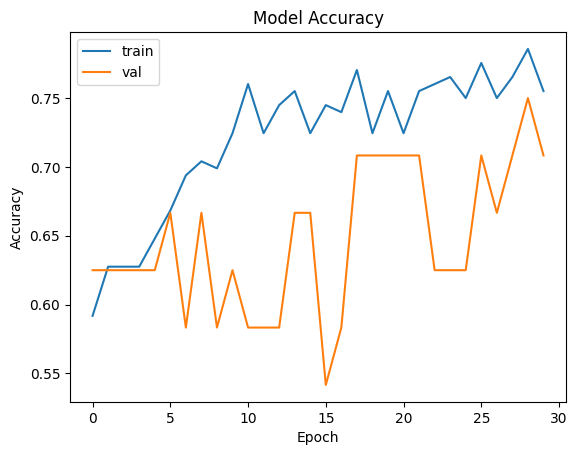

In [24]:
print("Accuracy Plot: ")
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss Plot: 


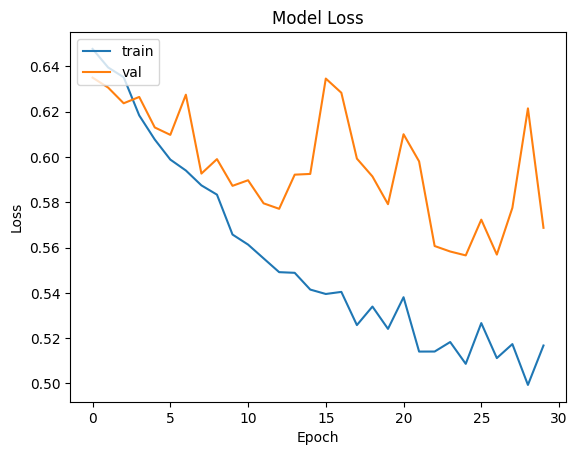

In [25]:
print("Loss Plot: ")
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
score = model.evaluate(test_generator, verbose=1)
print("Model performance on test data: ")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 29ms/step - loss: 0.5687 - accuracy: 0.7083
Model performance on test data: 
Test loss: 0.5687301754951477
Test accuracy: 0.7083333134651184


In [27]:
!pip install Pillow


In [28]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/brain_tumor_dataset/yes/Y106.jpg')
im.show()

In [29]:
image_path = '/content/drive/MyDrive/brain_tumor_dataset/yes/Y106.jpg'

In [30]:
SIZE=32
image_size = (SIZE,SIZE)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

img = load_img(image_path, target_size=image_size)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

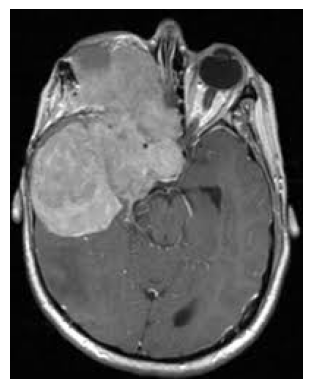

1/1 [==============================] - 0s 203ms/step
Prediction: Tumor


In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/drive/MyDrive/brain_tumor_dataset/yes/Y106.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

# Generate prediction
prediction = model.predict(img_array)
class_label = 'Tumor' if prediction[0][0] > 0.5 else 'Non-Tumor'
print('Prediction:', class_label)